In [2]:
import numpy as np
import pandas as pd
import scipy.optimize
import math
import quantopian.research
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline import Pipeline, CustomFilter
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def compute_mean(W, R):
    """
    Computes the expected return of a portfolio 
    Requires: List of asset weights and list of asset expected returns
    """
    mean=np.sum(W*R)
    return mean

def compute_var(W, C):
    """
    Computes the variance of a portfolio 
    Requires: List of asset weights and asset covariance matrix
    """
    var= np.dot(np.dot(W,C), W) 
    return var

def mean_var(W, R, C):
    """
    Calculates portfolio expected return and variance
    Requires: List of weights, list of asset expected returns, and asset covariance matrix.
    """
    mean= compute_mean(W,R)
    var= compute_var(W,C)
    return mean, var

In [4]:
def market_cap(price, shares_outstanding):
    return price*shares_outstanding

In [5]:
def sharpe_ratio(W, R, C, Rf):
    """
    Calculates a sharpe ratio of a portfolio
    Requires: Portfolio weights, list of asset returns, asset covariance matrix, risk free rate
    Sharpe ratio = (Mean portfolio return − Risk-free rate)/Standard deviation of portfolio return.

    """
    mean, var= mean_var(W, R, C) 
    return (mean- Rf)/ np.sqrt(var)

In [6]:
def sharpe(mean, std, rf):
    """
    Sharpe ratio = (Mean portfolio return − Risk-free rate)/Standard deviation of portfolio return.

    """
    return (mean- rf)/std

In [7]:
def w_fitness(W, R, C, Rf):
    if sharpe_ratio(W, R, C, Rf) < 0: 
        return 1000000000000
    else: 
        return 1/sharpe_ratio(W, R, C, Rf)

In [8]:
def solve_weights(R, C, Rf, low=0., high=1): 
    """
    Optimizes the list of assets using mean variance optimization, 
    Requires: expected returns, covariance matrix, risk free rate,
    low and high for upper and lower bounds for weight
    """
    n= len(R)
    W= np.ones([n])/n
    b_=[(low, high) for i in range(n)] 
    c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. }) 
    optimized = scipy.optimize.minimize(w_fitness, W, (R, C, Rf), method='SLSQP', constraints=c_, bounds=b_)
    if not optimized.success: #copied
        raise BaseException(optimized.message)
    return optimized.x

In [9]:
def solve_frontier(R, C, RF):
    def fitness(W, R, C, r):
        mean, var= mean_var(W, R, C)
        penalty= 100*abs(mean-r)
        return var+ penalty
    frontier_mean= []
    frontier_var= []
    n= len(R)
    for r in np.linspace(min(R), max (R), num= 20):
        W = np.ones([n]) / n  # start optimization with equal weights
        b_ = [(0, 1) for i in range(n)]
        c_ = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1.})
        optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)
        if not optimized.success:
            raise BaseException(optimized.message)
        frontier_mean.append(r)
        frontier_var.append(compute_var(optimized.x, C))
    return np.array(frontier_mean), np.array(frontier_var)

In [10]:
def optimize_frontier(R, C, rf):
    W = solve_weights(R, C, rf)
    tan_mean, tan_var = mean_var(W, R, C)  # calculate tangency portfolio
    front_mean, front_var = solve_frontier(R, C, rf)  # calculate efficient frontier
    result= {'weights': W, 'tangent_mean': tan_mean,'tangent_variance': tan_var}
    # Weights, Tangency portfolio asset means and variances
    return result, front_mean, front_var

In [11]:
def assetmeanvar(returns):  
    """
    Calculates the expected return and covariance matrix of the dataframe. 
    Requires: the returns dataframe.
    """
    covars=np.cov(np.matrix(returns).T)*250
    (rows, cols)= np.shape(returns)
    expectedreturns= np.array([])
    for i in range(cols):
        expectedreturns=np.append(expectedreturns,(1+np.mean(returns.iloc[:,i]))**250-1)
    return covars, expectedreturns
    

In [12]:
def weightsbymarketcap(returns, market_cap): 
    """
    Calculates the weights by market cap. 
    Requires: returns dataframe and the assets' respective market cap.
    """
    W=np.array([])
    total=0
    for column in returns.columns:
        total+= market_cap[column]
    for column in returns.columns:
        W=np.append(W, market_cap[column]/total)
    return W

In [13]:
def views_and_links(views, markcap, returns_columns):
    """
    Takes in a list of views to create a views vector. 
    Creates a links matrix that matches with the views vector, while accounting for market cap weights.
    Requires: list of views, dictionary of assets and their market caps, returns dataframe's column names
    """
    row, col = len(views), len(returns_columns)
    location= []
    Q= []
    for i in range(row): #finding the index for the > and < signs to divide the list between the greater and lesser sides.
        Q.append(views[i][-1])
        try:
            location.append(views[i].index('>'))
        except Exception:
            pass
        try:
            location.append(views[i].index('<'))
        except Exception:
            pass
    P = np.zeros([row, col])
    returnsindex=dict()
    for i, n in enumerate(returns_columns): #used to match the asset
        returnsindex[n]= i
    for i, v in enumerate(views):
        front=[]
        back=[]
        ftotal=0
        btotal=0
        for z in range(location[i]):
            x=views[i][z]
            front.append(x)
            ftotal+=markcap[x]
        for name in front:
            if views[i][location[i]]=='>': # match the link with the column index of the asset
                P[i, returnsindex[name]]= markcap[name]/ftotal #accounting for market cap weight on the greater side
            else:
                P[i, returnsindex[name]]= (markcap[name]*-1)/ftotal#accounting for market cap weight on the lesser side
        for z in range(location[i]+1,len(views[i])-1):
            x=views[i][z]
            back.append(x)
            btotal+=markcap[x]
        for name in back:
            if views[i][location[i]]=='<':
                P[i, returnsindex[name]]= markcap[name]/btotal #accounting for market cap weight on the greater side
            else:
                P[i, returnsindex[name]]= (markcap[name]*-1)/btotal#accounting for market cap weight on the lesser side
    return np.array(Q), P

In [14]:
def uncertainty_m(tau, C, P):
    """
    Creates a diagonal covariance matrix of error terms from the expressed views representing the uncertainty in each view (K x K matrix). 
    Requires: tau, covariance matrix, and views' links matrix
    """
    w = np.dot(np.dot(np.dot(tau, P),C),P.T)
    return w

In [15]:
def eqexcessret(tau, C, P, w, Q, eqRet):
    """
    Combines the different components to return the combined return vector
    Requires: tau, covariance matrix, views' links matrix, uncertainty matrix, views vector, equilibrium expected returns
    """
    sub_a = np.linalg.inv(np.dot(tau, C))
    sub_b = np.dot(np.dot(np.transpose(P), np.linalg.inv(w)), P)
    sub_c = np.dot(np.linalg.inv(np.dot(tau, C)), eqRet)
    sub_d = np.dot(np.dot(np.transpose(P), np.linalg.inv(w)), Q)
    eqRet_adj = np.dot(np.linalg.inv(sub_a + sub_b), (sub_c + sub_d))
    return eqRet_adj

In [16]:
def load_returns_data(symbols, start, end): 
    """
    Takes in the symbols for the assets to load pricing data and converts into daily returns, 
    Requires: asset symbols as a list, starting and ending dates 
    """
    data={}
    for symbol in symbols:
        data[symbol]=get_pricing(symbol, start_date=start, end_date=end, symbol_reference_date=None, frequency='daily', fields='price', handle_missing='raise', start_offset=0)
    returns={}
    for symbol in symbols:
        returns[symbol] = data[symbol].pct_change()[1:]
    returns_df=pd.DataFrame.from_dict(returns, orient='columns', dtype=None)
    returns_df=returns_df[symbols]
    return returns_df

In [17]:
def expectedreturn(symbols,returns_df):
    expectedreturn= np.array([])
    for symbol in symbols:
        expectedreturn=np.append(expectedreturn,(1+np.mean(returns_df[column]))**250-1)
    return expectedreturn

In [18]:
def lam(m, v, Rf): 
    """
    Calculates the risk aversion coefficient
    Requires: expected (market/ benchmark) return, 
    variance of the (market/benchmark) returns, 
    and risk free rate
    """
    lam= (m-Rf)/v
    return lam

In [19]:
def eqret(C, W, lam):
    """
    Calculates the implied equilibrium excess return by finding the dot products of lam, covariance matrix, and market weights
    Requires: Covariance matrix, market weights, and lambda
    """
    eqret= np.dot(np.dot(lam,C),W)
    return eqret

For years, the world has been excited about the opportunities of artificial intelligence in the field of finance. Largely, it’s because financial datasets are inherently large and complex making predicting investment trends near impossible without the assistance of programs. However, an easier problem to solve is the allocation of assets in an investment portfolios. Companies like Wealthfront have been touting investment robots that can help allocate investments using key investment principles like CAPM, Mean Variance Optimization, and Black Litterman. 

Following a careful evaluation of wealthfront’s investment white paper and their methodology, I’ve come to the conclusion that creating a Black Litterman portfolio optimizer is well within my means.

Every investor is looking to answer several questions: 
What assets to buy?
When to buy said assets?
How much of each asset to buy?
When to sell the assets?

A portfolio optimizer is mainly used to solve the third question; by optimizing the weights of each asset in the portfolio to maximize the sharpe ratio. However, what’s more about Black Litterman  is that it enables investors to combine their views regarding the performance of various assets with the market equilibrium in a manner that results in intuitive, diversified portfolios.


### Background

In order to build the optimizer, a more in depth understanding regarding Black Litterman model is required. Many of the material in this section is taken from the step by step guide to using Black Litterman. 
Black Litterman was created to address three main problems with the traditional mean variance optimization proposed as part of Harry Markowitz’s Modern Portfolio Theory: 1. Highly concentrated portfolios, 2. Input sensitivity, 3. Estimation error maximization. 

Mean variance optimized portfolios often yield extreme long short positions, and when constrained for only long positions, concentrates holdings in few assets. 

Input sensitivity refers to the fact that when using mean variance optimization, the resulting portfolio weights see massive changes when the expected returns of the assets change slightly. Black Litterman overcomes this by allowing investors to incorporate their own views to adjust the expected return. Finally, according to the guide and its cited report  has solved the problem of error maximization by spreading out the errors across the expected return vector. (I don’t fully understand this last error, so I’m going to simply assume it is correct.)

Step by step guide :http://valuestockselector.com/investingarticles/BlackLitterman.pdf
Report: https://www.jstor.org/stable/4479185?seq=1#page_scan_tab_contents


Based on the Wealthfront whitepaper, Wealthfront has two different ETF combinations based on the investors preference.  

In [20]:
symbols1= ['VTI', 'VEA', 'VWO', 'VIG', 'XLE', 'VTEB']
symbols2= ['VTI', 'VEA', 'VWO', 'VIG', 'VNQ', 'LQD','EMB']

We need to specify a start and end date for the period of historical pricing data for which we will be using to find the appropriate portfolio.

In [21]:
start= '2010-01-03'
end= '2015-01-03'

In [22]:
returns_df1=load_returns_data(symbols1, start, end)
returns_df2=load_returns_data(symbols2, start, end)
print returns_df1.head()
print returns_df1.tail()
print returns_df2.head()
print returns_df2.tail()

                                VTI       VEA       VWO       VIG       XLE  \
2010-01-05 00:00:00+00:00  0.003329  0.000564  0.004256 -0.000423  0.009870   
2010-01-06 00:00:00+00:00  0.001688  0.000298  0.005404  0.000846  0.011130   
2010-01-07 00:00:00+00:00  0.004212 -0.001988 -0.007245  0.004835 -0.002013   
2010-01-08 00:00:00+00:00  0.003279  0.008832  0.005653 -0.001051  0.006851   
2010-01-11 00:00:00+00:00  0.001387  0.007636  0.001161  0.006290 -0.001823   

                           VTEB  
2010-01-05 00:00:00+00:00   NaN  
2010-01-06 00:00:00+00:00   NaN  
2010-01-07 00:00:00+00:00   NaN  
2010-01-08 00:00:00+00:00   NaN  
2010-01-11 00:00:00+00:00   NaN  
                                VTI       VEA       VWO       VIG       XLE  \
2014-12-26 00:00:00+00:00  0.003177  0.003214  0.007294  0.000973  0.000000   
2014-12-29 00:00:00+00:00  0.001770 -0.006563 -0.003745 -0.000243  0.003496   
2014-12-30 00:00:00+00:00 -0.004649 -0.008843  0.002757 -0.003647 -0.007713   
2014-

Since VTEB doesn't have enough data to draw from as seen from the head and tail, we will be removing VTEB from the dataframes.

In [23]:
returns_df1=returns_df1.drop('VTEB', axis=1)
print(returns_df1.head())

                                VTI       VEA       VWO       VIG       XLE
2010-01-05 00:00:00+00:00  0.003329  0.000564  0.004256 -0.000423  0.009870
2010-01-06 00:00:00+00:00  0.001688  0.000298  0.005404  0.000846  0.011130
2010-01-07 00:00:00+00:00  0.004212 -0.001988 -0.007245  0.004835 -0.002013
2010-01-08 00:00:00+00:00  0.003279  0.008832  0.005653 -0.001051  0.006851
2010-01-11 00:00:00+00:00  0.001387  0.007636  0.001161  0.006290 -0.001823


We will analyze the first combination (returns_df1) before moving onto the second combination.

In [24]:
C1, R1= assetmeanvar(returns_df1)

In [25]:
display(pd.DataFrame(R1, columns=['Expected Returns'], index= returns_df1.columns).T)
print('Covariance Matrix')
display(pd.DataFrame(C1, columns=returns_df1.columns, index= returns_df1.columns))

,VTI,VEA,VWO,VIG,XLE
Expected Returns,0.167492,0.067939,0.035935,0.147877,0.106458


Covariance Matrix


,VTI,VEA,VWO,VIG,XLE
VTI,0.026690,0.030565,0.031271,0.022685,0.031603
VEA,0.030565,0.042698,0.040840,0.026362,0.037466
VWO,0.031271,0.040840,0.050083,0.026864,0.039206
VIG,0.022685,0.026362,0.026864,0.020282,0.027133
XLE,0.031603,0.037466,0.039206,0.027133,0.048352


Market cap will have to be hardcoded, since Quantopian does not offer market cap information on ETFs. We will use Net Asset Value to represent market cap.

In [26]:
Market_cap1={'VTI': 656960000000.000, 'VEA':104110000000.000, 'VWO': 89220000000.000, 'VIG':33550000000.000, 'XLE':16610000000.000}
Market_cap2={'VTI': 656960000000.000, 'VEA':104110000000.000, 'VWO': 89220000000.000, 'VIG':33550000000.000, 'VNQ':34630000000.000, 'LQD':38460000000.000, 'EMB':12470000000.000}

In [27]:
W1= weightsbymarketcap(returns_df1, Market_cap1)
W2= weightsbymarketcap(returns_df2, Market_cap2)

We'e going to first calculate the weights generated by utilizing mean variance optimization, which works to maximizethe Sharpe ratio. 

In [28]:
Rf=0.015  #setting the risk free rate at 1.5% 
W1_mvo=solve_weights(R1, C1, Rf)
display(pd.DataFrame([W1_mvo, W1], columns=returns_df1.columns, index= ['Weights_MVO', 'Weights_market_cap']))

,VTI,VEA,VWO,VIG,XLE
Weights_MVO,0.472223,5.898060e-17,0.000000,0.527777,0.000000
Weights_market_cap,0.729591,1.156200e-01,0.099084,0.037259,0.018446


As seen above, in using MVO, it often only optimizes the portfolio with two allocations. This is problematic, and counter intuitive since in a real market setting, it may be imprudent to only have two allocations.

In [29]:
m1,v1= mean_var(W1, R1, C1)
lam1= lam(m1, v1, Rf)
eqret1= eqret(C1, W1, lam1)
display(pd.DataFrame([R1,eqret1], columns=returns_df1.columns, index=['Expected Returns', 'Equilibrium Returns']))

,VTI,VEA,VWO,VIG,XLE
Expected Returns,0.167492,0.067939,0.035935,0.147877,0.106458
Equilibrium Returns,0.120637,0.144399,0.149952,0.103038,0.145366


In [30]:
W1_eq=solve_weights(eqret1+Rf, C1, Rf)


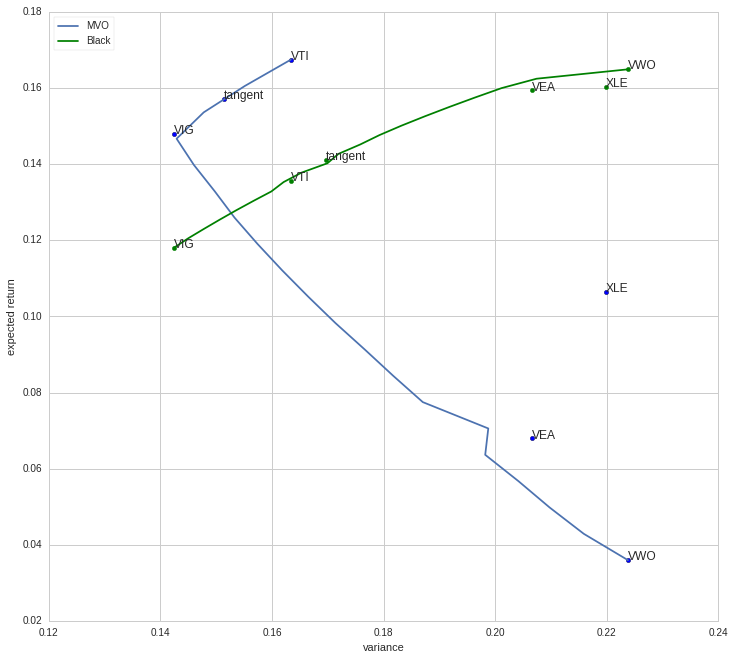

,VTI,VEA,VWO,VIG,XLE
Weights_MVO,0.472223,5.898060e-17,0.000000,0.527777,0.000000
Weights_market_cap,0.729591,1.156200e-01,0.099084,0.037259,0.018446
Equilibrium Weights,0.730696,1.155927e-01,0.098778,0.036141,0.018792


,expected_return,variance
MVO,0.157140,0.151355
Equilibrium,0.141108,0.169665


In [31]:
#Display the frontiers
result1, front_mean1, front_var1= optimize_frontier(R1, C1, Rf)
pairx1=[]
pairy1=[]
for i in range(len(R1)):
    pairx1.append(C1[i][i]**0.5)
    pairy1.append(R1[i])
fig= plt.figure(figsize=(12, 24))
ax= fig.add_subplot(2,1,1)
ax.scatter(pairx1, pairy1)
ax.plot(front_var1**0.5, front_mean1, label='MVO')
plt.xlabel('variance')
plt.ylabel('expected return')
ax.legend(loc='upper left')
for i, column in enumerate(returns_df1.columns):
    ax.annotate(returns_df1.columns[i], (pairx1[i], pairy1[i]))
ax.scatter(result1['tangent_variance']**0.5,result1['tangent_mean'])
ax.annotate('tangent',(result1['tangent_variance']**0.5,result1['tangent_mean']))
result1_eq, front_mean1_eq, front_var1_eq=optimize_frontier(eqret1+Rf, C1, Rf)
pair_eqy1=[]
for i in range(len(eqret1)):
    pair_eqy1.append(eqret1[i]+Rf)
pair_eqx1= pairx1
ax.scatter(pair_eqx1, pair_eqy1, color= 'green')
for i, column in enumerate(returns_df1.columns):
    ax.annotate(returns_df1.columns[i], (pair_eqx1[i], pair_eqy1[i]))  
ax.plot(front_var1_eq**0.5, front_mean1_eq, color= 'green', label='Black')
ax.scatter(result1_eq['tangent_variance']**0.5, result1_eq['tangent_mean'],color='green')
ax.annotate('tangent',(result1_eq['tangent_variance']**0.5, result1_eq['tangent_mean']))
ax.legend(loc='upper left')
plt.show()
display(pd.DataFrame([result1['weights'], W1, result1_eq['weights']], columns=returns_df1.columns, index= ['Weights_MVO', 'Weights_market_cap', 'Equilibrium Weights']))
display(pd.DataFrame([[result1['tangent_mean'], result1['tangent_variance']**0.5],[result1_eq['tangent_mean'], result1_eq['tangent_variance']**0.5]], index=['MVO', 'Equilibrium'], columns=['expected_return', 'variance']))


Through the graph, we can see how the expected(historical) returns form a efficient frontier (blue). Each point on the frontier represents a portfolio composition that minimizes variance at the specific expected return. The tangent portfolio on the blue curve is the MVO portfolio. We can also see how the curve is smoothed out through using reverse optimization with market weights in the first step of Black Litterman, and how the expected returns of each asset has shifted. It’s important to note each asset’s variance remains constant. The tangent point on the green curve represents the Equilibrium portfolio. 

As seen above, the equilibrium weights is very close to the weights by market cap. This is due to the fact that the weights equilibrium returns are derived from the market weights, and as such the equilibrium weights are only adjusted with the risk free return, thus the two are nearly identical.

##### Now we will analyze the second combination

In [32]:
C2, R2= assetmeanvar(returns_df2)

In [33]:
display(pd.DataFrame(R2, columns=['Expected Returns'], index= returns_df2.columns).T)
print('Covariance Matrix')
display(pd.DataFrame(C2, columns=returns_df2.columns, index= returns_df2.columns))

,VTI,VEA,VWO,VIG,VNQ,LQD,EMB
Expected Returns,0.167492,0.067939,0.035935,0.147877,0.195454,0.06909,0.062972


Covariance Matrix


,VTI,VEA,VWO,VIG,VNQ,LQD,EMB
VTI,0.026690,0.030565,0.031271,0.022685,0.027637,-0.000827,0.004601
VEA,0.030565,0.042698,0.040840,0.026362,0.031905,-0.000576,0.006464
VWO,0.031271,0.040840,0.050083,0.026864,0.033599,0.000090,0.007966
VIG,0.022685,0.026362,0.026864,0.020282,0.023275,-0.000766,0.003834
VNQ,0.027637,0.031905,0.033599,0.023275,0.042302,0.000770,0.006213
LQD,-0.000827,-0.000576,0.000090,-0.000766,0.000770,0.003001,0.001541
EMB,0.004601,0.006464,0.007966,0.003834,0.006213,0.001541,0.005556


In [34]:
m2,v2= mean_var(W2, R2, C2)
lam2= lam(m2, v2, Rf)
eqret2= eqret(C2, W2, lam2)
display(pd.DataFrame([R2,eqret2], columns=returns_df2.columns, index=['Expected Returns', 'Equilibrium Returns']))

,VTI,VEA,VWO,VIG,VNQ,LQD,EMB
Expected Returns,0.167492,0.067939,0.035935,0.147877,0.195454,0.069090,0.062972
Equilibrium Returns,0.126018,0.150806,0.156872,0.107548,0.133899,-0.002293,0.024348


In [35]:
W2_mvo=solve_weights(R2, C2, Rf)
display(pd.DataFrame([W2_mvo, W2], columns=returns_df2.columns, index= ['Weights_MVO', 'Weights_market_cap']))

,VTI,VEA,VWO,VIG,VNQ,LQD,EMB
Weights_MVO,0.091906,0.000000,2.988061e-16,0.168625,6.483529e-17,0.739469,0.000000
Weights_market_cap,0.677698,0.107396,9.203631e-02,0.034609,3.572313e-02,0.039674,0.012864


In [36]:
W2_eq=solve_weights(eqret2+Rf, C2, Rf)
display(pd.DataFrame([W2_mvo, W2, W2_eq], columns=returns_df2.columns, index= ['Weights_MVO', 'Weights_market_cap', 'Equilibrium Weights']))

,VTI,VEA,VWO,VIG,VNQ,LQD,EMB
Weights_MVO,0.091906,0.000000,2.988061e-16,0.168625,6.483529e-17,0.739469,0.000000
Weights_market_cap,0.677698,0.107396,9.203631e-02,0.034609,3.572313e-02,0.039674,0.012864
Equilibrium Weights,0.678749,0.107561,9.200531e-02,0.035630,3.586929e-02,0.036400,0.013785


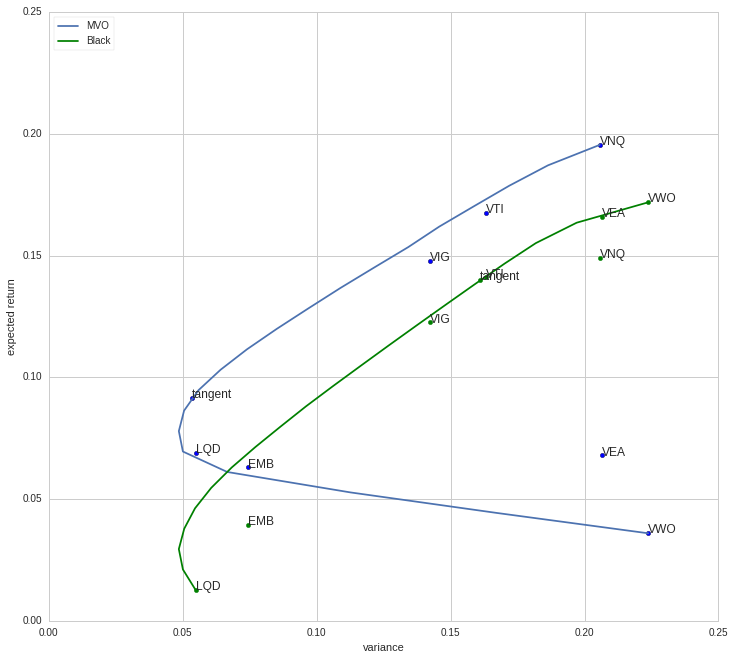

,VTI,VEA,VWO,VIG,VNQ,LQD,EMB
Weights_MVO,0.091906,0.000000,2.988061e-16,0.168625,6.483529e-17,0.739469,0.000000
Weights_market_cap,0.677698,0.107396,9.203631e-02,0.034609,3.572313e-02,0.039674,0.012864
Equilibrium Weights,0.678749,0.107561,9.200531e-02,0.035630,3.586929e-02,0.036400,0.013785


,expected_return,variance
MVO,0.091419,0.053317
Equilibrium,0.140075,0.160987


In [37]:
#Display the frontiers
result2, front_mean2, front_var2= optimize_frontier(R2, C2, Rf)
pairx2=[]
pairy2=[]
for i in range(len(R2)):
    pairx2.append(C2[i][i]**0.5)
    pairy2.append(R2[i])
fig2= plt.figure(figsize=(12,24))
ay= fig2.add_subplot(2,1,1)
plt.xlabel('variance')
plt.ylabel('expected return')
ay.scatter(pairx2, pairy2)
ay.plot(front_var2**0.5, front_mean2, label='MVO')
for i, column in enumerate(returns_df2.columns):
    ay.annotate(returns_df2.columns[i], (pairx2[i], pairy2[i]))
ay.scatter(result2['tangent_variance']**0.5,result2['tangent_mean'])
ay.annotate('tangent',(result2['tangent_variance']**0.5,result2['tangent_mean']))
result2_eq, front_mean2_eq, front_var2_eq=optimize_frontier(eqret2+Rf, C2, Rf)
pair_eqy2=[]
for i in range(len(eqret2)):
    pair_eqy2.append(eqret2[i]+Rf)
pair_eqx2= pairx2
ay.scatter(pair_eqx2, pair_eqy2, color= 'green')
for i, column in enumerate(returns_df2.columns):
    ay.annotate(returns_df2.columns[i], (pair_eqx2[i], pair_eqy2[i]))  
ay.plot(front_var2_eq**0.5, front_mean2_eq, color= 'green', label='Black')
ay.scatter(result2_eq['tangent_variance']**0.5, result2_eq['tangent_mean'],color='green')
ay.annotate('tangent',(result2_eq['tangent_variance']**0.5, result2_eq['tangent_mean']))
ay.legend(loc='upper left')
plt.show()
display(pd.DataFrame([result2['weights'], W2, result2_eq['weights']], columns=returns_df2.columns, index= ['Weights_MVO', 'Weights_market_cap', 'Equilibrium Weights']))
display(pd.DataFrame([[result2['tangent_mean'], result2['tangent_variance']**0.5],[result2_eq['tangent_mean'], result2_eq['tangent_variance']**0.5]], index=['MVO', 'Equilibrium'], columns=['expected_return', 'variance']))


In this second portfolio combination. The tangent for the equilibrium return actually was able to produce a higher return than that of the original MVO combination. 

##### Views

The greatest advantage offered by Black Letterman's model is the ability to incorporate views about the varying assets against one another. The original MVO model requires you to incorporate views for every single asset, meaning, you have to input a specific expected return for each asset. This isn't very practical as traders and portfolio managers often have views of the assets in relation to each other. For example, I could believe that Google will outperform Apple, but I wouldn't know if Google can outperform the market and by how much.

In order to incorporate views. We need to create a views matrix and an uncertainty matrix. For this section I will run the program for both combinations at the same time. The views I create are merely meant to show how it could affect the curves and the resulting tangent.  They do not reflect views that I hold for the market.

In [38]:
#First I need to create a list of views for each combination.

#Portfolio 1 views
views1 = [('VEA', '>','VWO', 0.03),
        ('XLE','VTI', '>', 'VIG', 0.02),
        ('VWO','<', 'XLE', 0.02)]
#Portfolio 2 views
views2 = [('VEA', '>','VWO', 0.03),
        ('VTI','VEA','>', 'VIG', 0.01),
        ('VWO','<', 'LQD', 0.02),
         ('LQD','>', 'EMB', 0.02)]

In [39]:
Q1, P1=views_and_links(views1, Market_cap1, returns_df1.columns)
print('the views matrix for portfolio 1')
print(Q1)
print('the links matrix for portfolio 1 ')
print(P1)
Q2, P2=views_and_links(views2, Market_cap2, returns_df2.columns)
print('the views matrix for portfolio 2')
print(Q2)
print('the links matrix for portfolio 2')
print(P2)

the views matrix for portfolio 1
[ 0.03  0.02  0.02]
the links matrix for portfolio 1 
[[ 0.          1.         -1.          0.          0.        ]
 [ 0.97534035  0.          0.         -1.          0.02465965]
 [ 0.          0.         -1.          0.          1.        ]]
the views matrix for portfolio 2
[ 0.03  0.01  0.02  0.02]
the links matrix for portfolio 2
[[ 0.          1.         -1.          0.          0.          0.          0.        ]
 [ 0.86320575  0.13679425  0.         -1.          0.          0.          0.        ]
 [ 0.          0.         -1.          0.          0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          1.         -1.        ]]


One of the main additions I've made to the code is for the links matrix to take in more than 2 assets to be compaired, as seen from the second statement in both views, there are 3 assets. I can add as many views as I want for as many different combinations I choose. The way to read the views is that VEA will out perform VWO by 3%. 

The other thing is that I made sure for the links matrix to account for market caps when there are more two assets, so as to balance the effects of the views

In [40]:
tau= 0.025 #approximation

In [41]:
w1= uncertainty_m(tau, C1, P1) #uncertainty matrix
print('uncertainty matrix for portfolio 1')
print(w1)
eqret1_adj=eqexcessret(tau, C1, P1, w1, Q1, eqret1)
print('\033[1m'+'equilibrium returns adjusted for views'+'\033[0m')
display(pd.DataFrame(eqret1_adj, index=returns_df1.columns, columns= ['Equilibrium Returns']).T)
w2= uncertainty_m(tau, C2, P2) #uncertainty matrix
print('uncertainty matrix for portfolio 2')
print(w2)
eqret2_adj=eqexcessret(tau, C2, P2, w2, Q2, eqret2)
print('\033[1m'+'equilibrium returns adjusted for views'+'\033[0m')
display(pd.DataFrame(eqret2_adj, index=returns_df2.columns, columns= ['Equilibrium Returns']).T)

uncertainty matrix for portfolio 1
[[  2.77537635e-04  -5.74638849e-06   1.87586896e-04]
 [ -5.74638849e-06   4.08134043e-05   7.01832220e-06]
 [  1.87586896e-04   7.01832220e-06   5.00577817e-04]]
equilibrium returns adjusted for views


,VTI,VEA,VWO,VIG,XLE
Equilibrium Returns,0.122698,0.150822,0.138599,0.104176,0.146305


uncertainty matrix for portfolio 2
[[  2.77537635e-04   3.66157866e-06   2.14424655e-04   2.09008807e-05]
 [  3.66157866e-06   4.52733786e-05  -1.43548380e-04  -2.61853230e-05]
 [  2.14424655e-04  -1.43548380e-04   1.32259762e-03   2.33412198e-04]
 [  2.09008807e-05  -2.61853230e-05   2.33412198e-04   1.36876141e-04]]
equilibrium returns adjusted for views


,VTI,VEA,VWO,VIG,VNQ,LQD,EMB
Equilibrium Returns,0.076121,0.086817,0.07485,0.061654,0.083884,0.005267,0.008588


Once we have the new equilibrium returns, we will solve for the optimal portfolio weights, returns, and variance.

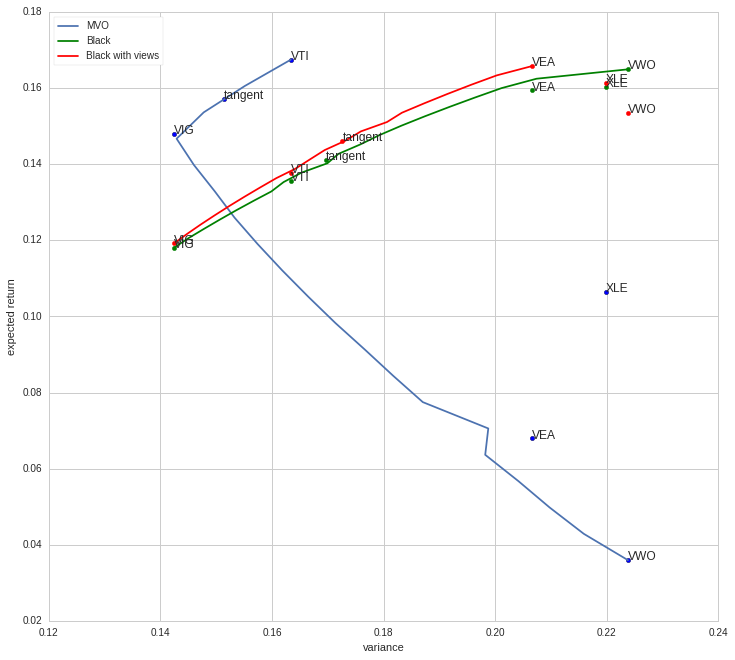

In [42]:
#Display the frontiers
result1, front_mean1, front_var1= optimize_frontier(R1, C1, Rf)
pairx1=[]
pairy1=[]
for i in range(len(R1)):
    pairx1.append(C1[i][i]**0.5)
    pairy1.append(R1[i])
fig= plt.figure(figsize=(12, 24))
ax= fig.add_subplot(2,1,1)
ax.scatter(pairx1, pairy1)
ax.plot(front_var1**0.5, front_mean1, label='MVO')
plt.xlabel('variance')
plt.ylabel('expected return')
for i, column in enumerate(returns_df1.columns):
    ax.annotate(returns_df1.columns[i], (pairx1[i], pairy1[i]))
ax.scatter(result1['tangent_variance']**0.5,result1['tangent_mean'])
ax.annotate('tangent',(result1['tangent_variance']**0.5,result1['tangent_mean']))
result1_eq, front_mean1_eq, front_var1_eq=optimize_frontier(eqret1+Rf, C1, Rf)
pair_eqy1=[]
for i in range(len(eqret1)):
    pair_eqy1.append(eqret1[i]+Rf)
pair_eqx1= pairx1
ax.scatter(pair_eqx1, pair_eqy1, color= 'green')
for i, column in enumerate(returns_df1.columns):
    ax.annotate(returns_df1.columns[i], (pair_eqx1[i], pair_eqy1[i]))  
ax.plot(front_var1_eq**0.5, front_mean1_eq, color= 'green', label='Black')
ax.scatter(result1_eq['tangent_variance']**0.5, result1_eq['tangent_mean'],color='green')
ax.annotate('tangent',(result1_eq['tangent_variance']**0.5, result1_eq['tangent_mean']))

result1_eqadj, front_mean1_eqadj, front_var1_eqadj= optimize_frontier(eqret1_adj+Rf, C1, Rf)
pair_eqadjy1=[]
for i in range(len(eqret1_adj)):
    pair_eqadjy1.append(eqret1_adj[i]+Rf)
pair_eqadjx1= pairx1
ax.scatter(pair_eqadjx1, pair_eqadjy1, color= 'red')
for i, column in enumerate(returns_df1.columns):
    ax.annotate(returns_df1.columns[i], (pair_eqadjx1[i], pair_eqadjy1[i]))  
ax.plot(front_var1_eqadj**0.5, front_mean1_eqadj, color= 'red', label='Black with views')
ax.scatter(result1_eqadj['tangent_variance']**0.5, result1_eqadj['tangent_mean'],color='red')
ax.annotate('tangent',(result1_eqadj['tangent_variance']**0.5, result1_eqadj['tangent_mean']))
ax.legend(loc='upper left')

result2_eqadj, front_mean2_eqadj, front_var2_eqadj= optimize_frontier(eqret2_adj+Rf, C2, Rf)

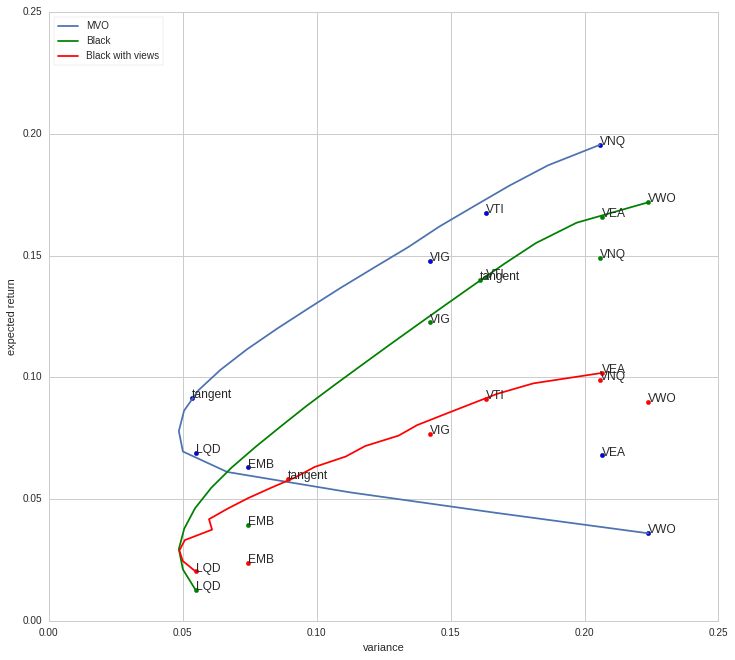

In [52]:
result2, front_mean2, front_var2= optimize_frontier(R2, C2, Rf)
pairx2=[]
pairy2=[]
for i in range(len(R2)):
    pairx2.append(C2[i][i]**0.5)
    pairy2.append(R2[i])
fig2= plt.figure(figsize=(12,24))
ay= fig2.add_subplot(2,1,1)
plt.xlabel('variance')
plt.ylabel('expected return')
ay.scatter(pairx2, pairy2)
ay.plot(front_var2**0.5, front_mean2, label='MVO')
for i, column in enumerate(returns_df2.columns):
    ay.annotate(returns_df2.columns[i], (pairx2[i], pairy2[i]))
ay.scatter(result2['tangent_variance']**0.5,result2['tangent_mean'])
ay.annotate('tangent',(result2['tangent_variance']**0.5,result2['tangent_mean']))
result2_eq, front_mean2_eq, front_var2_eq=optimize_frontier(eqret2+Rf, C2, Rf)
pair_eqy2=[]
for i in range(len(eqret2)):
    pair_eqy2.append(eqret2[i]+Rf)
pair_eqx2= pairx2
ay.scatter(pair_eqx2, pair_eqy2, color= 'green')
for i, column in enumerate(returns_df2.columns):
    ay.annotate(returns_df2.columns[i], (pair_eqx2[i], pair_eqy2[i]))  
ay.plot(front_var2_eq**0.5, front_mean2_eq, color= 'green', label='Black')
ay.scatter(result2_eq['tangent_variance']**0.5, result2_eq['tangent_mean'],color='green')
ay.annotate('tangent',(result2_eq['tangent_variance']**0.5, result2_eq['tangent_mean']))

result2_eqadj, front_mean2_eqadj, front_var2_eqadj= optimize_frontier(eqret2_adj+Rf, C2, Rf)
pair_eqadjy2=[]
for i in range(len(eqret2_adj)):
    pair_eqadjy2.append(eqret2_adj[i]+Rf)
pair_eqadjx2= pairx2

ay.scatter(pair_eqadjx2, pair_eqadjy2, color= 'red')
for i, column in enumerate(returns_df2.columns):
    ay.annotate(returns_df2.columns[i], (pair_eqadjx2[i], pair_eqadjy2[i]))  
ay.plot(front_var2_eqadj**0.5, front_mean2_eqadj, color= 'red', label='Black with views')
ay.scatter(result2_eqadj['tangent_variance']**0.5, result2_eqadj['tangent_mean'],color='red')
ay.annotate('tangent',(result2_eqadj['tangent_variance']**0.5, result2_eqadj['tangent_mean']))
ay.legend(loc='upper left')
plt.show()

As seen in both graphs, the frontiers are shifted and each asset's position has also been shifted. Showing that the views do affect the expected returns and the frontier. And that shift also shifts the tangent portfolio composition and return.

The next part is to evaluate how well the portfolio performs over the next 2 years based on the portfolio compositions suggested by the unadjusted portfolios. We use the unadjusted portfolios because we simply do not have the views to incorporate the market.

In [53]:
start_test= '2015-01-03'
end_test= '2015-01-03'
returns_df1_test=load_returns_data(returns_df1.columns, start, end)
display(pd.DataFrame([W1_mvo, W1_eq], columns=returns_df1.columns, index= ['Weights_MVO','Equilibrium Weights']))
returns_df2_test=load_returns_data(returns_df2.columns, start, end)
display(pd.DataFrame([W2_mvo, W2_eq], columns=returns_df2.columns, index= ['Weights_MVO','Equilibrium Weights']))

,VTI,VEA,VWO,VIG,XLE
Weights_MVO,0.472223,5.898060e-17,0.000000,0.527777,0.000000
Equilibrium Weights,0.730696,1.155927e-01,0.098778,0.036141,0.018792


,VTI,VEA,VWO,VIG,VNQ,LQD,EMB
Weights_MVO,0.091906,0.000000,2.988061e-16,0.168625,6.483529e-17,0.739469,0.000000
Equilibrium Weights,0.678749,0.107561,9.200531e-02,0.035630,3.586929e-02,0.036400,0.013785


In [54]:
daily_returns1_mvo_test=pd.DataFrame(np.dot(returns_df1_test, W1_mvo), index=returns_df1_test.index, columns=['Returns'])
daily_returns1_eq_test=pd.DataFrame(np.dot(returns_df1_test, W1_eq), index=returns_df1_test.index, columns=['Returns'])
daily_returns2_mvo_test=pd.DataFrame(np.dot(returns_df2_test, W2_mvo), index=returns_df2_test.index, columns=['Returns'])
daily_returns2_eq_test=pd.DataFrame(np.dot(returns_df2_test, W2_eq), index=returns_df2_test.index, columns=['Returns'])


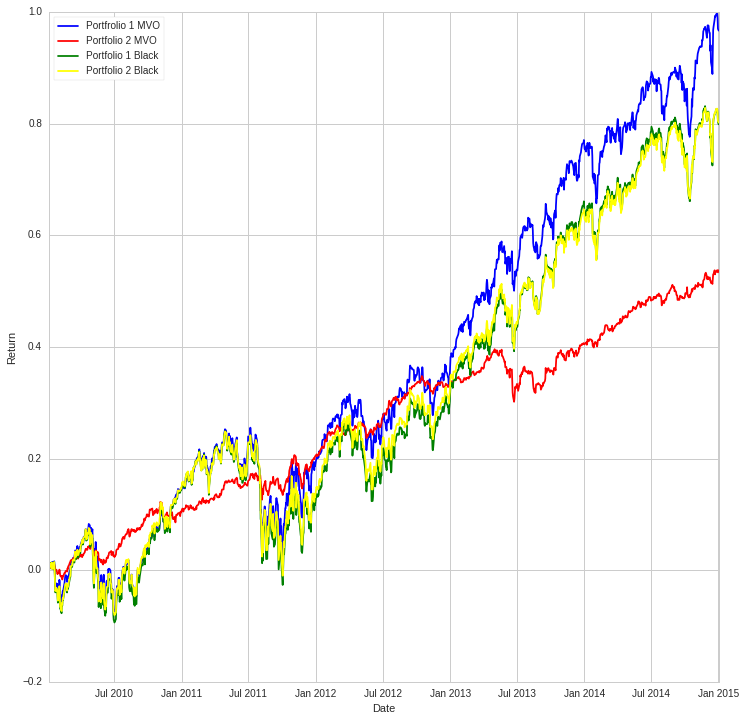

In [46]:
fig3=plt.figure(figsize=(12, 12))
az=fig3.add_subplot(1,1,1)
cum_returns1_mvo=((daily_returns1_mvo_test + 1).cumprod() - 1)
az.plot(cum_returns1_mvo, color='blue', label='Portfrolio 1 MVO')
cum_returns2_mvo=((daily_returns2_mvo_test + 1).cumprod() - 1)
az.plot(cum_returns2_mvo, color='red', label='Portfolio 2 MVO')
cum_returns1_eq=((daily_returns1_eq_test + 1).cumprod() - 1)
az.plot(cum_returns1_eq, color='green', label='Portfolio 1 Black')
cum_returns2_eq=((daily_returns2_eq_test + 1).cumprod() - 1)
az.plot(cum_returns2_eq, color='yellow', label='Portfolio 2 Black')
plt.xlabel('Date')
plt.ylabel('Return')
az.legend(loc='upper left')
plt.show()

Based of off returns, Portfolio Composition 1 using MVO is the best portfolio.

In [47]:
mvo_test_returns1= cum_returns1_mvo['Returns'].iloc[-1]
mvo_test_returns2= cum_returns2_mvo['Returns'].iloc[-1]
eq_test_returns1= cum_returns1_eq['Returns'].iloc[-1]
eq_test_returns2= cum_returns2_eq['Returns'].iloc[-1]
print('Portfolio 1 MVO Returns: '+str(mvo_test_returns1))
print('Portfolio 2 MVO Returns: '+str(mvo_test_returns2))
print('Portfolio 1 Black Equilibrium Returns: '+str(eq_test_returns1))
print('Portfolio 2 Black Equilibrium Returns: '+str(eq_test_returns2))

Portfolio 1 MVO Returns: 0.967095085655
Portfolio 2 MVO Returns: 0.537404806044
Portfolio 1 Black Equilibrium Returns: 0.799166514114
Portfolio 2 Black Equilibrium Returns: 0.802187171998


Based off of the std, Portfolio 2 using MOV is the best portfolio.

In [55]:
mvo_test_std1= daily_returns1_mvo_test['Returns'].std()
mvo_test_std2= daily_returns2_mvo_test['Returns'].std()
eq_test_std1= daily_returns1_eq_test['Returns'].std()
eq_test_std2= daily_returns2_eq_test['Returns'].std()
print('Portfolio 1 MVO Standard Deviation: '+str(mvo_test_std1))
print('Portfolio 2 MVO Standard Deviation: '+str(mvo_test_std2))
print('Portfolio 1 Black Equilibrium Standard Deviation: '+str(eq_test_std1))
print('Portfolio 2 Black Equilibrium Standard Deviation: '+str(eq_test_std2))

Portfolio 1 MVO Standard Deviation: 0.00957253713042
Portfolio 2 MVO Standard Deviation: 0.00337208442509
Portfolio 1 Black Equilibrium Standard Deviation: 0.010730527058
Portfolio 2 Black Equilibrium Standard Deviation: 0.0101816962995


In [56]:
mvo_annual_return1=np.sqrt(1+mvo_test_returns1)-1
mvo_annual_return2=np.sqrt(1+mvo_test_returns2)-1
eq_annual_return1=np.sqrt(1+eq_test_returns1)-1
eq_annual_return2=np.sqrt(1+eq_test_returns2)-1

mvo_test_sharpe1= sharpe(mvo_annual_return1, mvo_test_std1, Rf)
eq_test_sharpe1= sharpe(eq_annual_return1, eq_test_std1, Rf)
mvo_test_sharpe2= sharpe(mvo_annual_return2, mvo_test_std2, Rf)
eq_test_sharpe2= sharpe(eq_annual_return2, eq_test_std2, Rf)

Based on Sharpe Ratio, Portfolio 2 using MVO has the highest sharpe ratio.

In [57]:
collection1={}
for symbol in returns_df1_test.columns:
    asset={}
    asset['Cumulative Return']= ((returns_df1_test[symbol]+1).cumprod()-1)[-1]
    asset['Annual Return']= np.sqrt(asset['Cumulative Return']+1)-1
    asset['Standard Deviation']= returns_df1_test[symbol].std()
    asset['Sharpe Ratio']= sharpe(asset['Annual Return'], asset['Standard Deviation'], Rf)
    collection1[symbol]=asset 
coll1= pd.DataFrame(collection1, index=['Cumulative Return','Annual Return','Standard Deviation','Sharpe Ratio'], columns= returns_df1_test.columns )

display(coll1)

collection2={}
for symbol in returns_df2_test.columns:
    asset={}
    asset['Cumulative Return']= ((returns_df2_test[symbol]+1).cumprod()-1)[-1]
    asset['Annual Return']= np.sqrt(asset['Cumulative Return']+1)-1
    asset['Standard Deviation']= returns_df2_test[symbol].std()
    asset['Sharpe Ratio']= sharpe(asset['Annual Return'], asset['Standard Deviation'], Rf)
    collection2[symbol]=asset 
coll2= pd.DataFrame(collection2, index=['Cumulative Return','Annual Return','Standard Deviation','Sharpe Ratio'], columns= returns_df2_test.columns)

display(coll2)

,VTI,VEA,VWO,VIG,XLE
Cumulative Return,1.038095,0.250000,0.052856,0.902034,0.472723
Annual Return,0.427619,0.118034,0.026088,0.379142,0.213558
Standard Deviation,0.010332,0.013069,0.014154,0.009007,0.013907
Sharpe Ratio,39.934359,7.883997,0.783353,40.428619,14.277424


,VTI,VEA,VWO,VIG,VNQ,LQD,EMB
Cumulative Return,1.038095,0.250000,0.052856,0.902034,1.207900,0.389059,0.340849
Annual Return,0.427619,0.118034,0.026088,0.379142,0.485901,0.178584,0.157950
Standard Deviation,0.010332,0.013069,0.014154,0.009007,0.013008,0.003465,0.004714
Sharpe Ratio,39.934359,7.883997,0.783353,40.428619,36.200814,47.214463,30.324192


In [59]:
portfoliomvo1= {'Cumulative Return': cum_returns1_mvo['Returns'].iloc[-1], 'Annual Return': mvo_annual_return1, 'Standard Deviation': mvo_test_std1, 'Sharpe Ratio': mvo_test_sharpe1 }
portfoliomvo2= {'Cumulative Return': cum_returns2_mvo['Returns'].iloc[-1], 'Annual Return': mvo_annual_return2, 'Standard Deviation': mvo_test_std2, 'Sharpe Ratio': mvo_test_sharpe2 }
portfolioeq1={'Cumulative Return': cum_returns1_eq['Returns'].iloc[-1], 'Annual Return': eq_annual_return1, 'Standard Deviation': eq_test_std1, 'Sharpe Ratio': eq_test_sharpe1 }
portfolioeq2={'Cumulative Return': cum_returns2_eq['Returns'].iloc[-1], 'Annual Return': eq_annual_return2, 'Standard Deviation': eq_test_std2, 'Sharpe Ratio': eq_test_sharpe2 }
portcolls={'Portfolio 1 MVO': portfoliomvo1, 'Portfolio 2 MVO': portfoliomvo2, 'Portfolio 1 Black': portfolioeq1, 'Portfolio 2 Black': portfolioeq2}
portcolls_df= pd.DataFrame(portcolls, index=['Cumulative Return','Annual Return','Standard Deviation','Sharpe Ratio'], columns=['Portfolio 1 MVO','Portfolio 2 MVO', 'Portfolio 1 Black', 'Portfolio 2 Black'])

display(portcolls_df)

,Portfolio 1 MVO,Portfolio 2 MVO,Portfolio 1 Black,Portfolio 2 Black
Cumulative Return,0.967095,0.537405,0.799167,0.802187
Annual Return,0.402532,0.239921,0.341330,0.342456
Standard Deviation,0.009573,0.003372,0.010731,0.010182
Sharpe Ratio,40.483695,66.700966,30.411379,32.161208


This project takes inspiration from the following sources:

http://www.quantandfinancial.com/2013/08/black-litterman.html
https://github.com/omartinsky/QuantAndFinancial/blob/master/black_litterman/black_litterman.ipynb
A STEP-BY-STEP GUIDE TO THE BLACK-LITTERMAN MODEL  http://valuestockselector.com/investingarticles/BlackLitterman.pdf
https://research.wealthfront.com/whitepapers/investment-methodology/

Certain code snippets were edited or copied from 
https://github.com/omartinsky/QuantAndFinancial/blob/master/black_litterman/black_litterman.ipynb

